## Práctica de pre-procesamiento y del algoritmo KNN

- [Análisis Exploratorio de Datos](#Análisis-Exploratorio-de-Datos)
- [Transformación](#Transformación)
- [Detección de outliers](#Detección-de-outliers)
- [Estandarización](#Estandarización)
- [Problemas de regresión con el algoritmo KNN](#Problemas-de-regresión-con-el-algoritmo-KNN)
- [Problemas de clasificación con el algoritmo KNN](#Problemas-de-clasificación-con-el-algoritmo-KNN)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from test_helper import Test

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline  

### Lectura de Datos

En esta práctica vamos a trabajar con un problema de regresión. En concreto vamos a trabajar con el problema de la predicción del valor de una casa en base a su superficie y a su número de habitaciones. 

Para ello tenemos un fichero con el histórico de casas de  una empresa que tiene sede en Estados Unidos y en España: 
* El fichero es datosRegresion.txt y contiene casas caracterizadas por su superficie y su número de habitaciones de las que se dispone de su valoración.

Leer los datos almacenados en dicho fichero mediante la función *read_csv* de Pandas y genera dos DataFrames para almacenar los datos de entrada (X) y de salida (y).

In [41]:
# Creamos dos listas con los nombres de las variables de entrada y salida respecivamente
variablesEntrada =  list(pd.read_csv('datosRegresion.txt',usecols = [0,1],nrows=1).columns)
variableSalida =  list(pd.read_csv('datosRegresion.txt',usecols =[2],nrows=1).columns)

# Lectura de datos, el delimitador de atributos es la coma ','
datos = pd.read_csv('datosRegresion.txt')

# Generamos dos DataFrames: uno para la información de entrada (X) y otro para la de salida (y)
    # para acceder a los datos se debe usar el método loc 
    # para realizar una copia rompiendo la referencia a la variable original se debe usar el método copy
X = datos.loc[:,['Superficie','NumHabitaciones']].copy()
y = datos.loc[:,['Valoracion']].copy()

### Análisis exploratorio de datos

En primer lugar vamos a mostrar el resumen estadístico de la información de las variables de entrada y de salida. Para ello se puede utilizar el método *describe*: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

In [14]:
resumenEntrada = X.describe()
resumenSalida = y.describe()

Como las variables en las que recogemos los datos también son DataFrames podemos acceder fácilmente al contenido de cualquier valor estadístico. Se muestran varios ejemplos en la celda posterior.

In [15]:
# Acceso a las medias de todos los atributos de entrada
print(resumenEntrada.loc['mean', :])
# Acceso al mínimo de la superficie
print(resumenEntrada.loc['min', 'Superficie'])
# Acceso al mínimo y al máximo del número de habitaciones
print(resumenEntrada.loc[['min', 'max'], 'NumHabitaciones'])
# Acceso al conteo del número de valores de la valoración
print(resumenSalida.loc['count', 'Valoracion'])

Superficie         1685.280702
NumHabitaciones       3.649123
Name: mean, dtype: float64
98.0
min     1.0
max    30.0
Name: NumHabitaciones, dtype: float64
57.0


Vamos a mostrar gráficamente el contenido de las variables de entrada. 

Para ello, cread una gráfica compuesta por 2 subgráficas (1 filas y 2 columnas). Para acceder a cada subgráfica y mostrar lo que se desee en ella, se debe usar el método *subplot* de matplotlib: https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.subplot.html

Para facilitar la interpretación de las gráficas, es útil habilitar el grid, *plt.grid(True)*, y establecer los límites del eje y al mínimo y máximo de los valores de la variable a mostrar, *ylim((mínimo, máximo))*.

In [6]:
int(y.min(axis=0))

168999

<Figure size 1008x504 with 0 Axes>

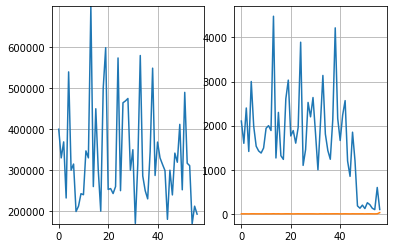

In [7]:
fig = plt.figure(figsize=(14,7))
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.set_ylim(int(y.min(axis=0)),int(y.max(axis=0)))
ax1.plot(y.values)
                           
ax2.plot(X.values)
                 
ax1.grid(True)
ax2.grid(True)

A continuación vamos a mostrar gráficamente la distribución de los datos de las variables de entrada junto con los diagramas de cajas y bigotes (boxplot). Para ello, cread una gráfica compuesta por 4 subgráficas (2 filas y 2 columnas).

En cada fila, en la columna izquierda mostrad la distribución de los datos de una variable usando *hist* (https://matplotlib.org/3.1.1/gallery/statistics/hist.html) y en la columna de la derecha mostrad el *boxplot* (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html) de la misma variable. Para poner títulos a los ejes se utilizan los métodos *xlabel* e *ylabel*.

NOTA: cread el histograma utilizando 20 contenedores (bins) y no determinéis el rango del eje y para la gráfica del histograma.

In [8]:
plt.figure(figsize=(16,10))
# <RELLENAR>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

Podemos observar que en la superficie existe un problema de escala (recordad que la empresa tiene sedes en EEUU y en España) ya que en el plot se observa que los últimos valores son mucho más pequeños que los primeros y esto se confirma en el histograma con la presencia de muchos datos cercanos a 0 y luego una distribución normal. Además, podemos ver que existen varios outliers. Con respecto al número de habitaciones, podemos observar que no existen problemas de escala pero que si que tenemos algún outlier en los datos.

### Transformación

En primer lugar vamos a tratar de solucionar el problema de escala. El hecho de que la empresa tenga sedes en EEUU y en España nos hace pensar que unas casas estarán medidas en pies cuadrados y otras en metros cuadrados (1 $m^2$ = 10,7639 $pies^2$). Por ello, debemos transformar todas las superficies medidas en pies cuadrados a metros cuadrados. Vamos a utilizar el valor 750 como umbral para decidir las casas medidas en una unidad métrica u otra (las mayores de 750 las consideraremos medidas en pies cuadrados).

In [16]:
def transformaSuperficie(X,s):
    mask = X[s]>750 
    X[s][mask] =X[s][mask] / 10.7639
    return X

In [42]:
X = transformaSuperficie(X,'Superficie')

In [43]:
Test.assertEquals(list(map(lambda x: round(x, 2), X['Superficie'].head())), [195.47, 148.65, 222.97, 131.55, 278.71], 'Superficies transformadas incorrectamente')

1 test passed.


Según la descripción del contenido de los ficheros podemos ver que existe un problema de escala ya que unas casas están medidas en pies cuadrados y otras en metros cuadrados. Un metro cuadrado equivale a 10,7639 pies cuadrados. 

Realiza una función llamada **transformaSuperficie** que reciba un dataset y el índice de la columna a tratar. La función debe devolver el dataset en el que los datos de la columna correspondiente ha sido transformada de pies cuadrados a metros cuadrados.

### Detección de outliers

En primer lugar vamos a implementar el método de detección de outliers basado en el rango intercuartil. Para ello, debéis implementar una función llamada *deteccionOutliers_IQR* que reciba como parámetros de entrada un DataFrame y el valor de k (por defecto debe ser 1.5) y devuelva como salida una lista con tantos booleanos como ejemplos y que en cada posición determine si ese ejemplo contiene outliers (True) o no (False).

NOTA 1: el método *logical_or* de Numpy realica la unión lógica de dos listas de booleanos.

NOTA 2: el método *any(axis=eje)* devuelve True si existe al menos un True en el *eje* que esté siendo consultado.

In [45]:
# Para calcular el IQR y los "putnos de corte" debéis utilizar el método describe y acceder a los campos apropiados
def deteccionOutliers_IQR(df,k=1.5):
    Q1=df.describe().loc['25%', :]
    Q2=df.describe().loc['50%', :]
    Q3=df.describe().loc['75%', :]
    IQR = Q3-Q1
    return np.logical_or(df > Q3 + k * IQR, df < Q1 - k * IQR).any(axis=1)

Ahora vamos a utilizar la función anterior para detectar outliers en los datos de entrada (X). Después, vamos a generar dos DataFrames (X_sinOut_IQR e y_sinOut_IQR) en los que eliminaremos los ejemplos que contengan outliers utilizando el valor 3.0 como valor de k.

NOTA 1: el método *logical_not* de Numpy realica la negación lógica de una lista de booleanos.

NOTA 2: recordad utilizar el método copy de Pandas para no perder el DataFrame X original.

In [53]:
# obtenemos el listado de booleanos que representa la presencia de outliers
outliers_IQR= deteccionOutliers_IQR(X,3)
X_sinOut_IQR = X[np.logical_not(outliers_IQR)].copy()
y_sinOut_IQR = y[np.logical_not(outliers_IQR)].copy()

In [54]:
Test.assertEquals(X_sinOut_IQR.shape, (55, 2), 'Dimensiones de X_sinOut_IQR incorrectas')
Test.assertEquals(y_sinOut_IQR.shape, (55, 1), 'Dimensiones de y_sinOut_IQR incorrectas')
Test.assertEquals(X.shape, (57, 2), 'Dimensiones de X original incorrectas')
Test.assertEquals(y.shape, (57, 1), 'Dimensiones de y original incorrectas')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


Ahora vamos a realizar el mismo proceso pero para el método de detección de outliers basado en la media y la desviación estándar explicado en clase de teoría. 

Definir una función llamda *deteccionOutliers_MeanStd* que reciba los datos sobre los que detectar los outliers y el valor de la variable k (por defecto debe ser 2). Esta función debe devolver una lista con tantos booleanos como ejemplos y que en cada posición determine si ese ejemplo contiene outliers (True) o no (False).

In [52]:
# Para calcular la media y la desviación debéis utilizar los métodos mean y std, respectivamente, y determinar el eje apropiado
def deteccionOutliers_MeanStd(df, k=1.5):
    mean = df.mean()
    std = df.std()
    return np.logical_or(df > mean + k * std, df < mean - k * std).any(axis=1)

Ahora vamos a utilizar la función anterior para detectar outliers en los datos de entrada (X). Después, vamos a generar dos DataFrames (X_sinOut_ms e y_sinOut_ms) en los que eliminaremos los ejemplos que contengan outliers utilizando el valor 3.0 como valor de k.

In [55]:
# obtenemos el listado de booleanos que representa la presencia de outliers
outliers_ms= deteccionOutliers_MeanStd(X,3)
X_sinOut_ms = X[np.logical_not(outliers_ms)].copy()
y_sinOut_ms = y[np.logical_not(outliers_ms)].copy()

In [56]:
Test.assertEquals(X_sinOut_ms.shape, (55, 2), 'Dimensiones de X_sinOut_ms incorrectas')
Test.assertEquals(y_sinOut_ms.shape, (55, 1), 'Dimensiones de y_sinOut_ms incorrectas')
Test.assertEquals(X.shape, (57, 2), 'Dimensiones de X original incorrectas')
Test.assertEquals(y.shape, (57, 1), 'Dimensiones de y original incorrectas')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


Para vuestra información, la librería *stats* de Scipy ofrece el método *zscore* (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) con el que se puede obtener el mismo resultado que con la función que acabamos de implementar. 

In [57]:
from scipy import stats
X_sinOut_ms_Scipy = X[(np.abs(stats.zscore(datos)) < 3.0).all(axis=1)].copy()
print(X_sinOut_ms_Scipy.shape)

(55, 2)


### Estandarización

Por útlimo, en los datos iniciales se puede observar que el rango de las dos variables de entrada es muy diferente. Por este motivo se debe realizar un proceso de estandarización de los datos para que todas las variables de entrada tengan el mismo rango y, por tanto, la misma importancia.

Vamos a realizar dos formas de realizar la estandarización. La primera de ellas es el método basado en la media y la desviación estándar. Se debe implementar una función llamada **estandarizarMediaStd** que reciba el DataFrame a estandarización y que realice el siguiente proceso:
* Calcular la media de los valores de todas las variables para todas las instancias
* Calcular la desviación estándar de los valores de todas las variables para todas las instancias
* A cada valor se le debe restar la media y el resultado dividirlo por la desviación estándar
* Devolver los datos estandarizados así como las medias y las desviaciones estándar calculadas

In [59]:
def estandarizarMediaStd(df):
    media = np.mean(df)
    std = np.std(df)
    datosEstandarizados = (df-media)/std
    return datosEstandarizados,media,std

Para estandarizar nuevos datos de test se debe realizar el mismo proceso que en el caso anterior pero, como son datos nuevos (datos de test), tenemos que utilizar la media y la desviación estándar obtenidas con los datos de entrenamiento. De esta forma la estandarización se realizará para todos los datos en las mismas condiciones. 

Definir una función llamda **estandarizarMediaStdTest** que estandarice nuevos datos de test que serán pasados como parámetros de entrada. Para ello se aplica la misma ecuación que para la función anterior pero utilizando la media y la desviación estándar pasadas como parámetros de entrada (serán las obtenidas con el conjunto de entrenamiento). La función devuelve los nuevos datos estandarizados.

In [60]:
def estandarizarMediaStdTest(df,media,std):
    datosEstandarizados = (df-media)/std
    return datosEstandarizados,media,std

La librería Scikit-Learn de Python nos provee una clase que realiza un proceso de estandarición similar (usa la varianza en lugar de la desviación estándar). Dicha clase está dentro de la librería *Preprocessing*. La clase en concreto que realiza este proceso es la llamada StandardScaler, cuya información se puede ver en la siguiente URL: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler. 

Para crear un objeto de esta clase es suficiente con llamar al constructor: preprocessing.StandardScaler(). Esta llamada devuelve un objeto con el que podemos llamar a varios métodos, los que vamos a utilizar son:
* fit: recibe como parámetro de entrada los datos de entrenamiento y calcula la media y la desviación estándar para cada variable. La media queda almacenada en el campo mean_ y la varianza en el campo var_.
* transform: recibe como parámetro de entrada los datos a estandarizar y devuelve los datos estandarizados utilizando los valores aprendidos previamente y almacenados en mean_ y var_.
* fit_transform: realiza el proceso de ambas funciones previamente descritas en una sola función.

In [61]:
from sklearn import preprocessing

normalizarScikitPorMedia = preprocessing.StandardScaler()

El segundo método de estandarización es el basado en el mínimo y el máximo de los datos de entrenamiento. Se debe implementar una función llamada **estandarizarMaxMin** que reciba el DataFrame a estandarizar y que realice el siguiente proceso:
* Calcular el mínimo de los valores de todas las variables para todas las instancias
* Calcular el máximo de los valores de todas las variables para todas las instancias
* A cada valor se le debe restar el mínimo y el resultado dividirlo por la diferencia entre el máximo y el mínimo
* Devolver los datos estandarizados así como los mínimos y los máximos calculados

In [81]:
def estandarizarMaxMin(df):
    df_min = np.min(df)
    df_max = np.max(df)
    datosEstandarizados = (df - df_min)/abs(df_max-df_min)
    return datosEstandarizados,df_min,df_max

Definir una función llamada **estandarizarMaxMinTest** que estandarice nuevos datos de test (pasados como argumento de entrada) utilizando los mínimos y los máximos. Para ello se aplica la misma ecuación que para la función anterior pero utilizando los mínimos y los máximos pasados como parámetros de entrada (serán los obtenidos con el conjunto de entrenamiento). La función devuelve los nuevos datos estandarizados.

In [63]:
def estandarizarMaxMinTest(df,df_min,df_max):
    datosEstandarizados = (df - df_min)/abs(df_max-df_min)
    return datosEstandarizados,minimo,maximo

La librería Scikit-Learn de Python también nos provee una clase que realiza este proceso de estandarización. La clase en concreto que realiza este proceso es la llamada MinMaxScaler, cuya información se puede ver en la siguiente URL: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler. 

Para crear un objeto de esta clase es suficiente con llamar al constructor: preprocessing.MinMaxScaler(). Esta llamada devuelve un objeto con el que podemos llamar a los mismos métodos explicados para la clase StandardScaler. En este caso el valor mínimo para cada variable (calculado con la función Fit) queda almacenado en el campo `data_min_` y el máximo en el campo `data_max_`.

In [64]:
normalizarScikitPorMinMax = preprocessing.MinMaxScaler()

### Problemas de regresión con el algoritmo KNN

A continuación vamos a aplicar todas las funciones definidas anteriormente para realizar la fase de solucionar el problema de la valoración de las casas. 

En este caso vamos a aplicar el algoritmo de los K vecinos más cercanos para problemas de regresión. La librería Scikit-Learn nos ofrece una implementación de dicho método que está dentro del paquete neighbors y cuya clase específica es KNeighborsRegressor, cuya información se puede consultar en la siguiente URL: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

Lo primero que se debe realizar es llamar a la función que crea el modelo de regresión. Esta función tiene varios parámetros que determinan el comportamiento del algoritmo. La llamada al constructor y sus parámetros son los siguientes:

    modeloRegresion = neighbors.KNeighborsRegressor(n_neighbors  = K, weights = tipoVoto, metric = tipoDistancia, p = r)

Los diferentes parámetros de entrada son
* n_neighbors = K: número de vecinos a considerar (valor por defecto = 5)
* weights = tipoVoto: forma de votar (peso de cada ejemplo cercano). tipoVoto puede tomar los siguientes valores:
    * 'uniform': voto por mayoría  (valor por defecto)
    * 'distance': voto en función de la inversa de la distancia
* metric = tipoDistancia: forma de calcular la distancia entre los ejemplos.  tipoDistancia puede tomar los siguientes valores:
    * 'manhattan': distancia de manhattan
    * 'euclidean': distancia euclidea
    * 'minkowski': distancia de Minkowski (valor por defecto)
* r: en caso de utilizar la distancia de Minkowski hay que especificar el valor del parámetro p que se corresponde al exponente r visto en la clase de teoría. r puede cualquier valor, entre ellos:
    * r = 1: distancia de manhattan
    * r = 2: distancia euclidea (valor por defecto)
    
Crear el modelo inicial con todos los valores por defecto. Almacenar el modelo en una variable.

In [65]:
from sklearn import neighbors

modeloReg = neighbors.KNeighborsRegressor()

Una vez creado el modelo debemos entrenarlo. Para ello se debe llamar al método *fit* del objeto creado anteriormente. A dicho método se le deben pasar los datos de entrenamiento (en este caso todos los datos disponibles) tanto de las variables de entrada como de la salida.

In [66]:
modeloReg.fit(X,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

Una vez que el modelo está entrenado lo podemos utilizar para realizar predicciones de nuevos datos. Para ello se debe llamar al método *predict* al que se pasa como parámetro de entrada los ejemplos a predecir (en este caso vamos a predecir el valor de todas las casas disponibles). Guardar el resultado de las predicciones en una variable.

In [67]:
predicciones=modeloReg.predict(X)

En este punto ya tenemos las predicciones de todas las casas por lo que podemos calcular el rendimiento del modelo. La librería Scikit-Learn ofrece una función que calcula el error cuadrático medio de las predicciones. Esta clase está dentro del paquete *metrics* y se llama *mean_squared_error* (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). A esta función se le pasa como argumentos de entrada los valores reales de los ejemplos y las predicciones realizadas por el modelo. Obviamente, devuelve el error cuadrático medio de las predicciones realizadas y para devovler el error en la escala original de los datos hay que hacer la raíz cuadrada del error devuelto por dicho método.

Utilizar dicha función para calcular el error cuadrático medio de las predicciones realizadas anteriormente y ponerlo en la escala original.

In [69]:
from sklearn.metrics import mean_squared_error

error =  mean_squared_error(y,predicciones,squared=False)
print(error)

72763.3677225258


In [70]:
Test.assertEquals(round(error, 2), 72763.37, 'Error incorrecto')

1 test passed.


Una vez que sabemos utilizar la librería de Scikit-Learn para aplicar el algoritmo KNN de regresión, vamos a utilizarla para entrenar KNN solamente con las casas que no tengan outliers (detectados por el método del rango intercuartil), predecir sus valores y obtener el error. ¿Es menor o mayor al de antes? ¿Tiene sentido?

In [71]:
modeloReg = modeloReg.fit(X_sinOut_IQR,y_sinOut_IQR)
predicciones = modeloReg.predict(X_sinOut_IQR)
error_sinOutliers = mean_squared_error(y_sinOut_IQR,predicciones,squared=False)

In [72]:
Test.assertEquals(round(error_sinOutliers, 2), 60858.18, 'Error incorrecto')

1 test passed.


Finalmente, vamos a estudiar la influencia de la estandarización de los datos a la hora de realizar las predicciones. En primer lugar vamos a realizar la estandarización por el método de la media y la desviación estándar.

Debéis realizar lo siguiente:
* Llamar a la función que hemos implementado para estandarizar los datos (sin los outliers detectados por el método del rango intercuartil) según este método.
* Realizar el aprendizaje con los ejemplos estandarizados
* Realizar la predicción de los ejemplos estandarizados
* Calcular el error cuadrático medio y ponerlo en su escala original

¿Es mayor o menor que el obtenido sin estandarizar los datos?

In [76]:
# Llamada a la función de estandarización de datos y aprendizaje del modelo
Xnorm,media,std = estandarizarMediaStd(X_sinOut_IQR)
modeloReg =  modeloReg.fit(Xnorm,y_sinOut_IQR)
predicciones = modeloReg.predict(Xnorm)
error_norm_ms = mean_squared_error(y_sinOut_IQR,predicciones,squared=False)

In [77]:
Test.assertEquals(round(error_norm_ms, 2), 60981.86, 'Error incorrecto')

1 test passed.


Realizar el mismo proceso que antes pero utilizando la estandarización por el máximo y el mínimo.

In [84]:
# Llamada a la función de estandarización de datos y aprendizaje del modelo
Xnorm, minimo, maximo = estandarizarMaxMin(X_sinOut_IQR)  
modeloReg =  modeloReg.fit(Xnorm,y_sinOut_IQR)
predicciones = modeloReg.predict(Xnorm)
error_norm_maxmin = mean_squared_error(y_sinOut_IQR,predicciones,squared=False)

In [85]:
Test.assertEquals(round(error_norm_maxmin, 2), 60398.23, 'Error incorrecto')

1 test passed.


### Problemas de clasificación con el algoritmo KNN

En esta segunda parte de la práctica vamos a trabajar con un problema de clasificación. En concreto vamos a trabajar con el problema de la predicción de si un microchip pasa los tests de calidad o no en base a dos pruebas que se les han realizado.

Leer los datos almacenados en el fichero datosClasificacion.txt mediante la función mediante la función *read_csv* de Pandas. Almacenar los datos en una variable llamada datosClasificacion y genera dos DataFrames para almacenar los datos de entrada (X) y de salida (y).

In [88]:
# Creamos dos listas con los nombres de las variables de entrada y salida respecivamente
variablesEntrada =  ['Prueba1','Prueba2']
variableSalida =  ['Clase']
# Lectura de datos, el delimitador de atributos es la coma ','
datosClasificacion = pd.read_csv('datosClasificacion.txt')
# Generamos dos DataFrames: uno para la información de entrada (X) y otro para la de salida (y)
    # para acceder a los datos se debe usar el método loc 
    # para realizar una copia rompiendo la referencia a la variable original se debe usar el método copy
X = datosClasificacion.loc[:,variablesEntrada]
y = datosClasificacion.loc[:,variableSalida]

Normalizar los datos de entrada con el método de la media y la desviación estándar ofrecito por la librería Scikit-Learn. Mostrar los valores de los 5 primeros ejemplos.

In [89]:
# Se crea el objeto para realizar la normalización por la media y la desviación
myStandardScaler = preprocessing.StandardScaler()
# Se entrena el objeto y se transofman los datos de entrada
Xnorm = myStandardScaler.fit_transform(X)
print(Xnorm[:5,:])

[[-0.00710129  0.99791805]
 [-0.29829632  0.9696688 ]
 [-0.54290103  0.98379343]
 [-0.8690393   0.61655322]
 [-1.14858928  0.5459301 ]]


En este caso, al ser un problema de clasificación, debemos aplicar el algoritmo KNN para problemas de clasificación. La librería Scikit-Learn nos ofrece una implementación de dicho método que está dentro del paquete neighbors y cuya clase específica es KNeighborsClassifier, cuya información se puede consultar en la siguiente URL: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

Esta clase funciona exactamente igual que la que soluciona problemas de regresión.
    
Crear el modelo inicial con todos los valores por defecto. Almacenar el modelo en una variable.

In [90]:
modeloClas = neighbors.KNeighborsClassifier()

El entrenamiento (fit) y la predicción de nuevos ejemplos (predict) se realizan igual que antes.

Sin embargo, para obtener el rendimiento del clasificador debemos aplicar otras funciones de la librería metrics. En concreto vamos a aplicar:
* accuracy_score: los parámetros de entrada son las clases reales y las predicciones y devuelve el ratio de ejemplos correctamente clasificados.
    * URL: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
* confusion_matrix: los parámetros de entrada son las clases reales y las predicciones y devuelve la matriz de confusión.
    * URL: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
* classification_report: los parámetros de entrada son las clases reales y las predicciones y devuelve varias medidas de rendimiento como la precisión, el recall, la medida F1 y el soporte (número real de ejemplos de cada clase).
    * URL: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

Entrenar el clasificador con los datos normalizados, realizar sus predicciones y mostrar el resultado de las tres funciones de rendimiento anteriores.

NOTA: como la variable con la información de salida (y) es un DataFrame, para acceder a su contenido tendréis que hacer y['nombreVariableSalida'].

In [105]:
from sklearn import metrics

# Entrenamineto del modelo
modeloClas = modeloClas.fit(Xnorm,y['Clase'].ravel())
# Predicciones de los datos
predicciones = modeloClas.predict(Xnorm)
# Cálculo del accuracy
accuracy = metrics.accuracy_score(y,predicciones)
# print accuracy
print(accuracy)
# Cálculo de la matriz de confusión
matrizConfusion = metrics.confusion_matrix(y,predicciones)

print(accuracy)
print(matrizConfusion)
print(metrics.classification_report(y['Clase'], predicciones))

0.847457627118644
0.847457627118644
[[48 12]
 [ 6 52]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        60
           1       0.81      0.90      0.85        58

    accuracy                           0.85       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.85      0.85      0.85       118



In [106]:
Test.assertEquals(round(accuracy, 5), 0.84746, 'Accuracy incorrecto')
Test.assertEquals(list(map(lambda ind: ind, list(matrizConfusion.ravel()))), [48, 12, 6, 52], 'Matriz de confusion incorrecta')

1 test passed.
1 test passed.


Ahora, vamos analizar el efecto de los parámetros del algoritmo KNN en los resultados obtenidos (accuracy rate):
* Número de vecinos (parámetro n_neighbors)
    * Probar los resultados con 1, 3, 5 y 7 vecinos

In [109]:
# Lista con los accuracies por cada valor k
accScikit = []
for k in [1,3,5,7]:
#     # Creación del modelo
    modeloClas = neighbors.KNeighborsClassifier(n_neighbors=k)
#     # Entrenamiento del modelo
    modeloClas = modeloClas.fit(Xnorm,y['Clase'].ravel())
#     # Predicciones de los datos
    predicciones = modeloClas.predict(Xnorm)
#     # Cálculo del accuracy rate
    accuracy = metrics.accuracy_score(y,predicciones)
#     # Se añade el accuracy a la lista
    accScikit.append(accuracy)
#     # Se muestra el número de vecinos y el accuracy
    print(k,accuracy)

1 1.0
3 0.8559322033898306
5 0.847457627118644
7 0.8305084745762712


In [110]:
Test.assertEquals(list(map(lambda ind: round(ind, 3), list(accScikit))), [1.0, 0.856, 0.847, 0.831], 'Accuracies incorrectos')

1 test passed.


Utilizando un número de vecinos igual a 3, vamos a analizar el efecto de la forma de votación.
* Tipo de voto (parámetro weights)
    * Probar los valores 'uniform', 'distance'

In [112]:
# Lista con los accuracies por cada tipo de voto
n_neighbors = 3
accScikit = []
for tipoVoto in ['uniform','distance']:
#     # Creación del modelo
    modeloClas = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors,weights=tipoVoto)
#     # Entrenamiento del modelo
    modeloClas = modeloClas.fit(Xnorm,y['Clase'].ravel())
#     # Predicciones de los datos
    predicciones = modeloClas.predict(Xnorm)
#     # Cálculo del accuracy rate
    accuracy = metrics.accuracy_score(y,predicciones)
#     # Se añade el accuracy a la lista
    accScikit.append(accuracy)
#     # Se muestra el tipo de voto y el accuracy
#     print tipoVoto, accuracy
    print (tipoVoto, accuracy)

uniform 0.8559322033898306
distance 1.0


In [113]:
Test.assertEquals(list(map(lambda ind: round(ind, 3), list(accScikit))), [0.856, 1.0], 'Accuracies incorrectos')

1 test passed.


Utilizando un número de vecinos igual a 3, vamos a analizar el efecto de la forma de votación.
* Tipo de distancia (parámetro metric)
    * Probar los valores 'manhattan', 'euclidean'

In [115]:
# Lista con los accuracies por cada tipo de voto
k = 3
accScikit = []
for tipoDistancia in ['manhattan','euclidean']:
#     # Creación del modelo
    modeloClas = neighbors.KNeighborsClassifier(n_neighbors=k,metric=tipoDistancia)
#     # Entrenamiento del modelo
    modeloClas = modeloClas.fit(Xnorm,y['Clase'].ravel())
#     # Predicciones de los datos
    predicciones = modeloClas.predict(Xnorm)
#     # Cálculo del accuracy rate
    accuracy = metrics.accuracy_score(y,predicciones)
#     # Se añade el accuracy a la lista
    accScikit.append(accuracy)
#     # Se muestra el tipo de distancia y el accuracy
#     print tipoDistancia, accuracy
    print (tipoDistancia, accuracy)

manhattan 0.8813559322033898
euclidean 0.8559322033898306


In [116]:
Test.assertEquals(list(map(lambda ind: round(ind, 3), list(accScikit))), [0.881, 0.856], 'Accuracies incorrectos')

1 test passed.


Por último, vamos a visualizar la frontera de decisión que genera el clasificador KNN. Debéis hacer lo siguiente:
* Aprender el clasificador con los datos normalizados utilizando 3 vecinos, y la distancia de Manhattan. (A realizar)
* Se crea una nube de puntos con todas las combinaciones entre el mínimo (-0.1) y el máximo (+0.1) con incrementos de 0.02 de las dos variables.
* Se realiza la predicción de todos los ejemplos generados.
* Se crea la gráfica donde la predicción de cada clase sale en dieferentes colores (contour) y se muestran los ejemplos de entrenamiento (scatter)

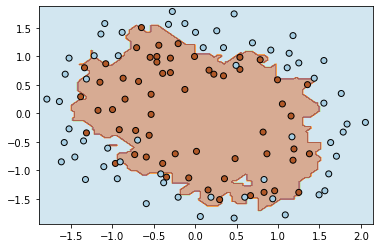

In [120]:
# Creación del modelo
modeloClas = neighbors.KNeighborsClassifier(n_neighbors=3,metric='manhattan')
# Entrenamiento del modelo
modeloClas = modeloClas.fit(Xnorm,y['Clase'].ravel())

#se crea una gráfica para mostrar la superficie de decisión del clasificador aprendido
h = .02  # tamaño de avance en el mesh
#TAREA: calcula el mínimo (menos 1) y el máximo (más 1) de las variables de entrada
x0_min = Xnorm[:, 0].min() - 0.1
x0_max = Xnorm[:, 0].max() + 0.1
x1_min = Xnorm[:, 1].min() - 0.1
x1_max = Xnorm[:, 1].max() + 0.1

# Se crean todas las combinaciones de valores
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
# Se predicen todos los puntos de la superficio de la gráfica con el clasificador aprendido
Z = modeloClas.predict(np.c_[xx0.ravel(), xx1.ravel()])

#Se muestran los resultados en la gráfica: la función contourf colorea toda la superficie
Z = Z.reshape(xx0.shape)
plt.figure(1)
plt.contourf(xx0, xx1, Z, cmap=plt.cm.Paired, alpha=0.5)

#Se muestran los datos del problema: la funcion scatter muestra puntos aislados y los colorea en función de su valor
plt.scatter(Xnorm[:, 0], Xnorm[:, 1], c=y['Clase'], cmap=plt.cm.Paired, edgecolors='k')
#se muestra la figura
plt.show()